In [1]:
! pip install gym-super-mario-bros

     |████████████████████████████████| 199 kB 706 kB/s eta 0:00:01
     |████████████████████████████████| 77 kB 1.3 MB/s eta 0:00:01
  Created wheel for nes-py: filename=nes_py-8.2.1-cp38-cp38-linux_x86_64.whl size=497197 sha256=8507ce6b2c91157953bde54aa84d55c73bbc2d8fcb6ea9c1fc49a0b4e0719098
  Stored in directory: /home/sakib/.cache/pip/wheels/17/e5/5c/8dfae61b44dbf56c458483aa09accef55a650e0527f6cbd872
Successfully built nes-py


In [12]:
# importing dependencies for mario
import tensorflow as tf
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace
from IPython.display import clear_output

from tensorflow.keras.models import save_model, load_model
import time

In [2]:
tf.__version__

'2.3.1'

In [19]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)

In [29]:
total_reward = 0
done = True

for step in range(100000):
    env.render()
    if done:
        state = env.reset()
        
    state, reward,done,info = env.step(env.action_space.sample())
    print(info)

    total_reward += reward
    clear_output(wait = True)
        
env.close()

KeyboardInterrupt: 

In [8]:
env.close()

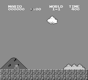

In [10]:
state = env.reset()
preprocess_state(state)

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        #create the variables for our agent
        self.state_space = state_size
        self.action_space = action_size
        self.memory = deque(maxlen = 5000)
        self.chosenAction = 0
        
        #hyperparams
        self.gamma = 0.8
        self.epsilon = 1
        self.max_epsilon = 1
        self.min_epsilon = 0.01
        self.decay_epsilon = 0.0001
        
        #building neural network for agent
        self.main_network = self.build_network()
        self.target_network = self.build_network()
        self.update_target_network()
        
    
    def build_network(self):
        model = Sequential()
        model.add(Conv2D(32, (4,4), strides = 4, padding = 'same', input_shape = self.state_space))
        model.add(Activation('relu'))
        
        model.add(Conv2D(16, (3,3), strides = 2, padding = 'same'))
        model.add (Activation ('relu'))
        model.add(Flatten())
        
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        
        model.compile(loss = 'mse', optimizer = Adam())
        
        return model
    
    
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())
    
    
    def act(self, state, onGround):
        
        if onGround < 83:
            print("On Ground")
            if random.uniform(0, 1) < self.epsilon:
                self.chosenAction = np.random.randint(self.action_space)
                return self.chosenAction

            Q_value = self.main_network.predict(state)
            self.chosenAction = np.argmax(Q_value[0])
            print(Q_value)

            return self.chosenAction
        else:
            print("not On Ground")
            return self.chosenAction
    def update_epsilon(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_epsilon * episode)

    
    def train(self, batch_size):
        # minibatch from memory
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = self.main_network.predict(state)
            
            if done:
                target[0][action] = reward
                
            else:
                target[0][action] = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
                
                
            self.main_network.fit(state, target, epochs = 1, verbose = 0)
            
            
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        

In [15]:
action_space = env.action_space.n
state_space = (80,88,1)
#env.observation_space

from PIL import Image

def preprocess_state (state):
    image = Image.fromarray(state)
    image = image.resize((88, 80))
    image = image.convert('L')
    image = np.array(image)
    #image.show()
    
    return image



In [16]:
num_episodes = 1000000
num_timesteps = 40000
batch_size = 64
DEBUG_LENGTH = 300

In [6]:
dqn = DQNAgent(state_space, action_space)

2022-07-01 18:47:35.287256: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sakib/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-01 18:47:35.287278: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 18:47:35.287292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sakib-MS-7C83): /proc/driver/nvidia/version does not exist
2022-07-01 18:47:35.287452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 18:47:35.316743: 

In [20]:
print('starting training')

stuck_buffer = deque(maxlen = DEBUG_LENGTH)

for i in range (num_episodes):
    Return = 0
    done = False
    time_step = 0
    
    state = preprocess_state(env.reset())
    state = state.reshape(-1, 80, 88, 1)
    
    onGround = 79
    
    
    for t in range(num_timesteps):
        env.render()
        time_step += 1
        if done:
            env.reset()
            break
        
        
            
        
        
        if t > 1 and stuck_buffer.count(stuck_buffer[-1]) > DEBUG_LENGTH - 50:
            action = dqn.act(state, onGround = 79)
        else:
            action = dqn.act(state, onGround)
        #action = dqn.act(state, onGround)
        next_state, reward, done, info = env.step(action)
        
        
        
        onGround = info['y_pos']
        #time.sleep(0.01)
        print(f'ACTION is: {action}')
        stuck_buffer.append(info['x_pos'])
        
        next_state = preprocess_state(next_state)
        next_state = next_state.reshape(-1, 80, 88, 1)
        
        dqn.store_transition(state, action, reward, next_state, done)
        
        Return += reward
        
        print(f'Episode: {i}\nTotal Time Step: {time_step}\nCurrent Reward: {Return}\nEpsilon: {dqn.epsilon}')
        clear_output(wait = True)
        
        
        if len(dqn.memory) > batch_size and i > 1:
            dqn.train(batch_size)
            
        
    dqn.update_epsilon(i)
    clear_output(wait = True)
    dqn.update_target_network()
    
    
env.close()

KeyboardInterrupt: 

In [21]:
env.close()